
# Sử dụng mô hình Generative Adversial Network (GAN) huấn luyện trên tập dữ liệu MNIST và MNIST Fashion




Mô hình GAN sử dụng 2 mạng huấn luyện là mạng Generator - G và mạng Discriminator - D. Mạng Generator sẽ cố gắng tạo ra những tập dữ liệu mới từ tập dữ liệu ban đầu, còn mạng Discriminator có nhiệm vụ phân biệt đâu là tập dữ liệu cũ và đâu là tập dữ liệu mới tạo ra.

# Quá trình chuẩn bị

In [ ]:
import torch
import torch.optim as opt
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np 
import matplotlib.pyplot as plt
import torch.optim as optim
import pickle as pkl
%matplotlib inline

Ở bước chuẩn bị dữ liệu ban đầu cần phải transform tập dữ liệu để có thể sử dụng với pytorch

In [ ]:
# number of subprocesses to use for data loading
numWorkers = 0

# Chia mẫu thành các mini-batch
batchSize = 64

# transform dữ liệu sang kiểu tensor để pytorch có thể hoạt động được
transform = transforms.ToTensor()

# Handwriting digits
trainData = torchvision.datasets.MNIST(root='data', train=True, download=True, transform=transform)
# MNIST Fashion
# train_data = torchvision.datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)

# Data Loader
trainLoader = torch.utils.data.DataLoader(trainData, batch_size=batchSize,num_workers=numWorkers)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



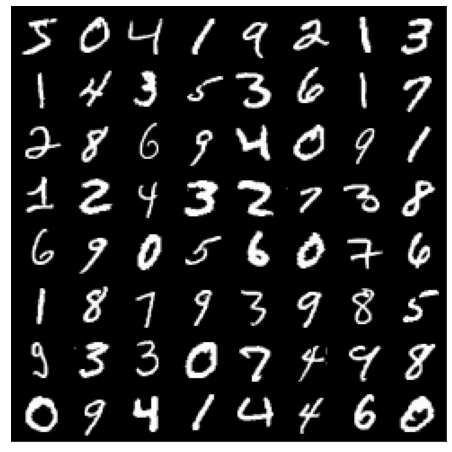

torch.Size([64, 1, 28, 28])


In [ ]:
#Hiển thị một số hình ảnh của MNIST

dataiter = iter(trainLoader)
imgs, labels = dataiter.next()

def visualizeDatasets(imgs):

    # make_grid - Tạo layout hiện thị các 
    imgs = torchvision.utils.make_grid(imgs)
    
    # transfoming ngược lại từ tensor sang dạng numpy để có thể thể hiện ảnh
    npimgs = imgs.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimgs, (1,2,0)), cmap='Greys_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()

visualizeDatasets(imgs)

print(imgs.size())

# Mạng Discriminator

- Đầu vào của mạng Discrimnator là ảnh thực hoặc ảnh được tạo ra từ mạng Generator. Đầu ra của mạng là 0 hoặc 1 thể hiện cho kết của ảnh là giả / thật 
- Sử dụng Linear Regression cho quá trình huấn luyện
- Sử dụng hàm kích hoạt Leaky ReLu
- Sau mỗi lớp Linear Regression, ta sẽ dùng thêm dropout để loại bỏ một số mẫu, giúp tranhs việc bị overfitting


In [ ]:
class Discriminator(nn.Module):

    def __init__(self, inputSize, hiddenDim, outputSize):
        super(Discriminator, self).__init__()
        
        # define hidden linear layers
        self.model = nn.Sequential(
            nn.Linear(inputSize, hiddenDim*4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hiddenDim*4, hiddenDim*2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hiddenDim*2, hiddenDim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hiddenDim, outputSize),
        )
        
    def forward(self, input):
        # flatten image
        input = input.view(-1, 28*28)
        out = self.model(input)

        return out

# Mạng Generator
- Đầu vào của mạng Generator là tập hợp các vector nhiễu khởi tạo ngẫu nhiên theo phân phối Gaussian.
- Sử dụng Linear Regression cho quá trình huấn luyện
- Sử dụng hàm kích hoạt Leaky ReLu
- Hàm kích hoạt cho lớp cuối cùng là Tanh giúp mở rộng khoảng giá trị [-1, 1] thay vì [0, 1] như Sigmoid

In [ ]:
class Generator(nn.Module):

    def __init__(self, inputSize, hiddenDim, outputSize):
        super(Generator, self).__init__()
        
        # define hidden linear layers
        self.model = nn.Sequential(
            nn.Linear(inputSize, hiddenDim),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hiddenDim, hiddenDim*2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hiddenDim*2, hiddenDim*4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(hiddenDim*4, outputSize),
        )

    def forward(self, input):
        
        # final layer with tanh applied
        out = torch.tanh(self.model(input))

        return out

#Các tham số sử dụng của các mạng

In [ ]:
# Tham số mạng Discriminator

# Kích thước ảnh đầu vào của mạng discriminator (28*28)
inputSize = 784
# Kích thước đầu ra của mạng discriminator (real or fake)
dOutputSize = 1
# Kích thước lớp hidden layer cuối discriminator
dHiddenSize = 32

# Tham số mạng Generator

# Kích thước vector nhiễu generator
zSize = 100
#  Kích thước lớp hidden layer cuối generator
gHiddenSize = 32
# Kích thước ảnh đẩu ra của mạng generator (generated image)
gOutputSize = 784

# Khai báo mạng Generator & Discriminator

In [ ]:
D = Discriminator(inputSize, dHiddenSize, dOutputSize)
G = Generator(zSize, gHiddenSize, gOutputSize)

print(D)
print(G)

Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=32, out_features=1, bias=True)
  )
)
Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=32, out_features=64, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=12

# Tính toán hàm mất mát của mạng Discriminator & Generator

- Hàm mất mát của mạng Discriminator
  - Lượng mất mát của mạng Discriminator được tính bằng tổng mất mát trên dữ liệu ban đầu và mất mát trên dữ liệu mới tạo ra.
  - Bởi đầu ra của mạng Discriminator là 1 hoặc 0 nên giá trị mất mát của mạng sẽ phải thể hiện được điều đó
  - Hàm mất mát của mạng sẽ sử dụng **BCEWithLogitsLoss** dựa trên hàm Sigmoid và hàm BCE - Binary Cross Entropy
  - Để giúp cho mạng Discriminator có thể phân biệt tốt hơn thì ta có thể giảm label từ 1.0 xu 0.9. Hàm sẽ sử dụng tham số **smooth**, nếu **smooth = True** thì ta sẽ tiến hành smooth label bằng cách **labels = torch.ones(size) * 0.9**  
  - Với tập dữ liệu giả do Generator tạo ra, ta mong muốn D(fake) = 0

- Hàm mất mát của mạng Generator
  - Hàm mất mát của mạng G tính toán giống với của Discrimination nhưng với những label bị ngược. Mục tiêu của Generator là để D(fake) = 1.



In [ ]:
# Tính toán mất mát
def realLoss(D_out, smooth=False):
    batchSize = D_out.size(0)
    
    if smooth:
        
        labels = torch.ones(batchSize)*0.9
    else:
        labels = torch.ones(batchSize) 
        
    # Tính loss với Sigmoid và BCE
    criterion = nn.BCEWithLogitsLoss()
  
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fakeLoss(D_out):
    batchSize = D_out.size(0)
    
    labels = torch.zeros(batchSize) 
    
    criterion = nn.BCEWithLogitsLoss()
    
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Tối ưu

Ở đây ta muốn cập nhật tham số cho mạng Discriminator và Generator 1 cách độc lập.\
Ta sử dụng 2 hàm Adam để thực hiện tối ưu


In [ ]:

# Optimizers
learingRate = 1e-3

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), learingRate)
g_optimizer = optim.Adam(G.parameters(), learingRate)

# Quy trình huấn luyện
Quá trính huấn luyện cho mạng Discriminator và mạng Generator diễn ra đồng thời trong 1 epoch. Ta sẽ sử dụng hàm **real_loss** và **fake_loss** để tính mất mát của mạng Discriminator

### Quá trình huấn luyện mạng Discriminator
1. Tính hàm loss của Discrimtator dựa trên ảnh gốc trong tập ảnh test        
2. Tiến hành sinh ảnh giả
3. Tính hàm loss của mạng Discrimination trên ảnh giả     
4. Cộng kết quả 2 hàm loss khi tính trên ảnh thật và ảnh sinh
5. Thực hiện lan truyền ngược và tối ưu để cập nhật tham số cho mạng Discriminator

### Quá trình huấn luyện mạng Generator
1. Sinh ảnh giả
2. Tính hàm loss của mạng generator
3. Thực hiện lan truyền ngược và tối ưu để cập nhật tham số cho mạng Generator

#### Lưu mẫu

Lưu lại các kết quả mất mát sau mỗi bước training. Để sử dụng trong việc đánh giá kết quả trên từng bước và thống kê.

In [ ]:

# Epochs training
numEpochs = 100

# Lưu lại kết quả của hàm mất mát và các mẫu sinh
samples = []
losses = []

printEvery = 400

# Tập vector nhiều ngẫu nhiên
sampleSize=16
fixedZ = np.random.uniform(-1, 1, size=(sampleSize, zSize))
fixedZ = torch.from_numpy(fixedZ).float()

# Bắt đầu huấn luyện các mạng
D.train()
G.train()
for epoch in range(numEpochs):
    
    for batchI, (realImages, _) in enumerate(trainLoader):
                
        batchSize = realImages.size(0)
        
        ## Rescale ảnh sử dụng cho Leaky ReLU
        realImages = realImages*2 - 1  # input từ [0,1) cho [-1, 1)
        
        # ============================================
        #            Huấn luyện cho DISCRIMINATOR
        # ============================================
        
        # set d_optimizer = 0 chuẩn bị cho lan truyền ngược
        d_optimizer.zero_grad()
        
        # 1. Huấn luyện với ảnh train

        # Tính hàm mất mát của discriminator với ảnh train 
        # sử dụng smooth với real labels
        D_real = D(realImages)
        d_realLoss = realLoss(D_real, smooth=True)
        
        # 2. Huấn luyện với ảnh sinh
        
        # Sinh ảnh giả
        # không sử dụng gradient cho ảnh sinh ở trong quá trình huấn luyện discriminator
        with torch.no_grad():
            z = np.random.uniform(-1, 1, size=(batchSize, zSize))
            z = torch.from_numpy(z).float()
            fakeImages = G(z)
        
        # Tính hàm mất mát của discriminator với ảnh sinh        
        D_fake = D(fakeImages)
        d_fakeLoss = fakeLoss(D_fake)
        
        # Cộng kết quả 2 hàm loss khi tính trên ảnh thật và ảnh sinh
        d_loss = d_realLoss + d_fakeLoss

        # Lan truyền ngược + tối ưu + cập nhật hệ số
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            Huấn luyện GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Huấn luyện với ảnh sinh vầ label ngược
        
        # Tạo ảnh sinh
        z = np.random.uniform(-1, 1, size=(batchSize, zSize))
        z = torch.from_numpy(z).float()
        fakeImages = G(z)
        
        # Tính hàm mất mát của discriminator với ảnh sinh nhưng với label ngược
        D_fake = D(fakeImages)
        g_loss = realLoss(D_fake) # sử  dụng real_loss thay vì fake_loss vì label ngược
        
        # Lan truyền ngược + tối ưu + cập nhật hệ số
        g_loss.backward()
        g_optimizer.step()

        # Print
        if batchI % printEvery == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, numEpochs, d_loss.item(), g_loss.item()))

    
    ## Sau mỗi epoch
    # bổ sung discriminator loss and generator loss
    losses.append((d_loss.item(), g_loss.item()))
    
    # tạo và lưu mẫu sinh
    G.eval() # eval mode - chuyển sang chể độ đánh giá
    samplesZ = G(fixedZ)
    samples.append(samplesZ)
    G.train()


# Lưu lại tất cả các mẫu đã sinh
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/  100] | d_loss: 0.8391 | g_loss: 1.9404
Epoch [    1/  100] | d_loss: 1.0376 | g_loss: 1.3799
Epoch [    1/  100] | d_loss: 1.1022 | g_loss: 1.0925
Epoch [    2/  100] | d_loss: 1.3061 | g_loss: 0.6165
Epoch [    2/  100] | d_loss: 0.7483 | g_loss: 2.3734
Epoch [    2/  100] | d_loss: 1.2843 | g_loss: 0.9723
Epoch [    3/  100] | d_loss: 1.4041 | g_loss: 0.7835
Epoch [    3/  100] | d_loss: 1.0493 | g_loss: 1.1307
Epoch [    3/  100] | d_loss: 1.1831 | g_loss: 1.0926
Epoch [    4/  100] | d_loss: 1.1622 | g_loss: 1.1851
Epoch [    4/  100] | d_loss: 0.9186 | g_loss: 2.1041
Epoch [    4/  100] | d_loss: 0.9464 | g_loss: 1.6780
Epoch [    5/  100] | d_loss: 1.0740 | g_loss: 1.7728
Epoch [    5/  100] | d_loss: 0.9765 | g_loss: 1.7058
Epoch [    5/  100] | d_loss: 1.1968 | g_loss: 1.4140
Epoch [    6/  100] | d_loss: 1.1871 | g_loss: 1.5576
Epoch [    6/  100] | d_loss: 1.2305 | g_loss: 1.1939
Epoch [    6/  100] | d_loss: 1.1650 | g_loss: 1.2695
Epoch [    7/  100] | d_loss

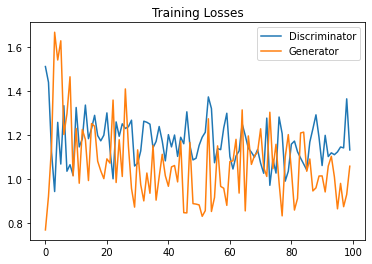

In [ ]:
# Bảng thể hiện kết quả của hàm mất mát của 2 mạng/mô hình
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Xem lại các ảnh sinh trong quá trình huấn luyện


In [ ]:
def viewSamples(epoch, samples):
    fig, axes = plt.subplots(figsize=(8,8), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [ ]:
# Lấy các mẫu từ file được lưu từ trước
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

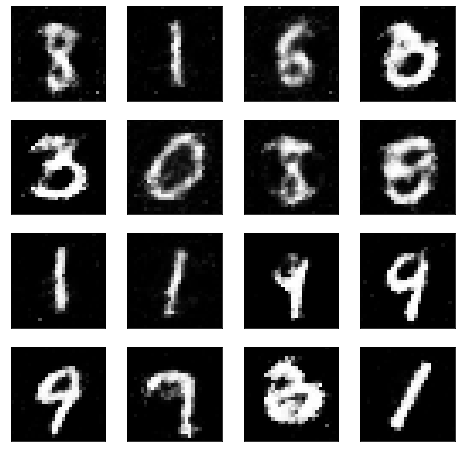

In [ ]:
# -1 => kết quả của epoch cuối
viewSamples(-1, samples)

Các ảnh sinh ra ở mỗi X epoch

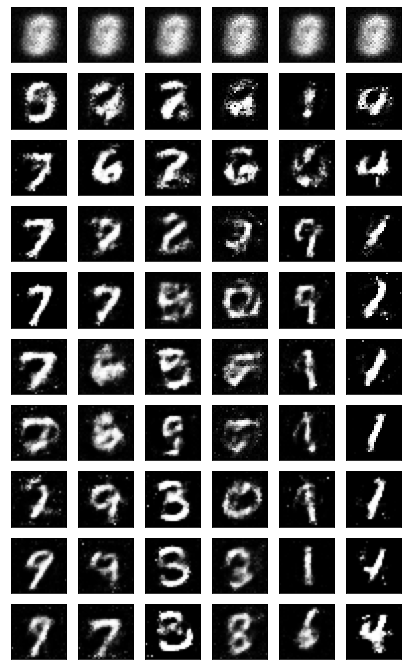

In [ ]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

## Tự sinh ra ảnh từ kết quả training của mạng Generator

Có thể tạo ra một ảnh mới từ kết quả training bằng cách sử dụng checkpoint mà ta đã lưu được\
Chỉ cần truyền 1 vector nhiễu là có thể sinh ra ảnh sinh tại điểm checkpoint đó




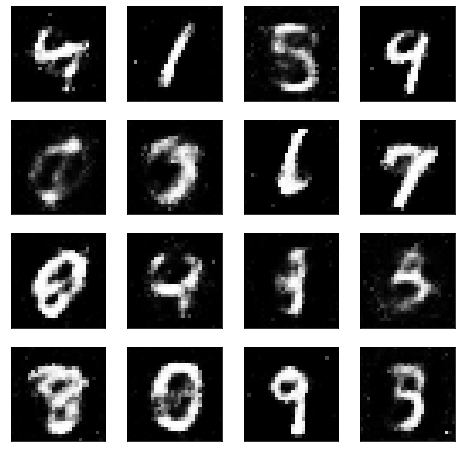

In [ ]:
# Vector nhiễu z ngẫu nhiên 
sampleSize=16
randZ = np.random.uniform(-1, 1, size=(sampleSize, zSize))
randZ = torch.from_numpy(randZ).float()

G.eval() # eval mode
# generated samples
randImages = G(randZ)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
viewSamples(0, [randImages])